In [4]:
# Import TensorFlow and other libraries
from __future__ import print_function, division

import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

import datetime
import sys
import os
from imageio import imread
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
print(os.listdir("../input"))

['person-face-sketches']


In [5]:
import os
from PIL import Image
import numpy as np

# Base path to the dataset
base_path = '../input/person-face-sketches/'
output_base_path = './Sketch2Face/'

# List of dataset splits (train, val, test)
dataset_splits = ['train', 'val', 'test']

# Create the output base directory if it does not exist
os.makedirs(output_base_path, exist_ok=True)

# Function to combine two images side by side
def combine_images(photo, sketch):
    # If the sketch is grayscale (2D), convert it to RGB by stacking along the color channel
    if len(sketch.shape) == 2:
        sketch = np.stack((sketch,)*3, axis=-1)  # Convert grayscale to RGB
    combined_image = np.hstack((photo, sketch))  # Combine images horizontally
    return Image.fromarray(combined_image)

# Iterate through the dataset splits (train, val, test)
for split in dataset_splits:
    photos_path = os.path.join(base_path, split, 'photos')
    sketches_path = os.path.join(base_path, split, 'sketches')
    output_path = os.path.join(output_base_path, split)

    # Create the output directory for this split if it does not exist
    os.makedirs(output_path, exist_ok=True)

    # Iterate through the files in the photos directory
    for filename in os.listdir(photos_path):
        if filename.endswith('.jpg'):  # Process only .jpg files
            # Load the photo and sketch images
            photo_image = Image.open(os.path.join(photos_path, filename))
            sketch_image = Image.open(os.path.join(sketches_path, filename))

            # Convert images to the same size (optional: depending on dataset consistency)
            sketch_image = sketch_image.resize(photo_image.size)

            # Convert the images to numpy arrays
            photo_array = np.array(photo_image)
            sketch_array = np.array(sketch_image)

            # Combine the photo and sketch images
            combined_image = combine_images(photo_array, sketch_array)

            # Save the combined image in the output directory
            combined_image.save(os.path.join(output_path, filename))

            print(f"Processed and saved: {filename} in {split} split")

print("Image combination for all dataset splits (train, val, test) completed!")


Processed and saved: 19812.jpg in train split
Processed and saved: 22735.jpg in train split
Processed and saved: 16916.jpg in train split
Processed and saved: 22706.jpg in train split
Processed and saved: 12666.jpg in train split
Processed and saved: 13288.jpg in train split
Processed and saved: 20088.jpg in train split
Processed and saved: 28578.jpg in train split
Processed and saved: 22288.jpg in train split
Processed and saved: 24819.jpg in train split
Processed and saved: 6241.jpg in train split
Processed and saved: 25540.jpg in train split
Processed and saved: 20529.jpg in train split
Processed and saved: 27582.jpg in train split
Processed and saved: 623.jpg in train split
Processed and saved: 2193.jpg in train split
Processed and saved: 14143.jpg in train split
Processed and saved: 21440.jpg in train split
Processed and saved: 3750.jpg in train split
Processed and saved: 11378.jpg in train split
Processed and saved: 2008.jpg in train split
Processed and saved: 10730.jpg in train 

In [6]:
import tensorflow as tf

# Check if TensorFlow is using a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU!")
else:
    print("TensorFlow is using the CPU!")


Num GPUs Available:  0
TensorFlow is using the CPU!


### Load the dataset

In [7]:
PATH = 'Sketch2Face/'
sample_image = tf.io.read_file(str(PATH + 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(512, 1024, 3)


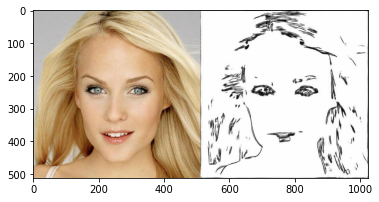

In [8]:
plt.figure()
plt.imshow(sample_image);

we need to separate real building facade images from the architecture label images—all of which will be of size 256 x 256.

In [9]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

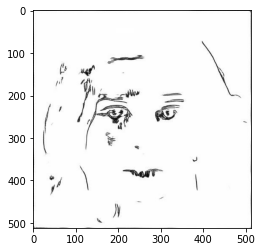

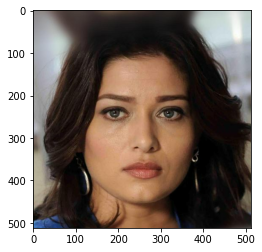

In [10]:
inp, re = load(str(PATH + 'train/1854.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0);
plt.figure()
plt.imshow(re / 255.0);

As described in the pix2pix paper, we need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

* Resize each 256 x 256 image to a larger height and width—286 x 286.
* Randomly crop it back to 256 x 256.
* Randomly flip the image horizontally i.e. left to right (random mirroring).
* Normalize the images to the [-1, 1] range.


In [14]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256




def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image



def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]



# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [15]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


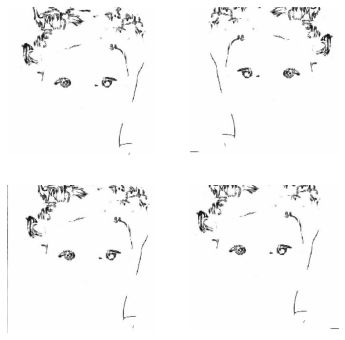

In [16]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [17]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH + 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
try:
    test_dataset = tf.data.Dataset.list_files(str(PATH +'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH + 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


In [25]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
generator = Generator()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


NameError: name 'Generator' is not defined

In [27]:
LAMBDA = 100


loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss


In [28]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

### Visualize the discriminator model architecture:

In [ ]:
discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss


In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [32]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [33]:
log_dir="./logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [34]:
gen_gan_loss_list = []
gen_l1_loss_list = []
gen_total_loss_list = []
disc_loss_list = []
data = 0
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    if (step) % 1000 == 0:
      if step != 0:
        tf.print('Discriminator loss: ', disc_loss)
        tf.print('Generator GAN loss: ',gen_gan_loss)
        tf.print('Generator L1 loss: ',gen_l1_loss)
        tf.print('Generator total loss: ',gen_total_loss)
    
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
 

In [35]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      #display.clear_output(wait=True)

      if step != 0:
        print(f'\nTime taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)


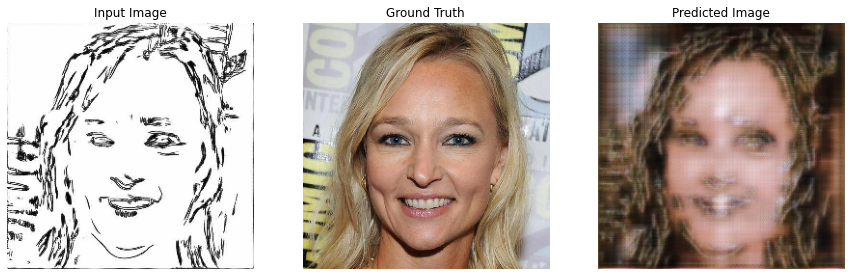

Step: 0k
....................................................................................................
Time taken for 1000 steps: 1274.33 sec



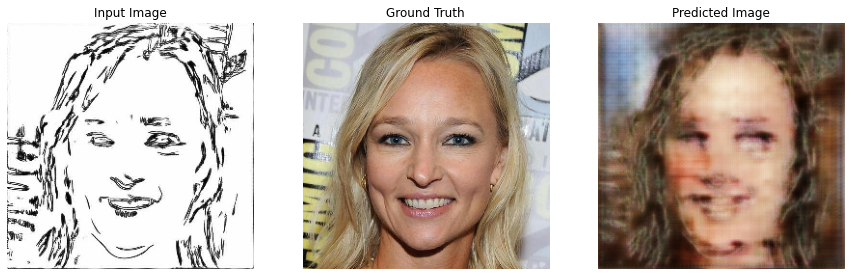

Step: 1k
Discriminator loss:  2.12326932
Generator GAN loss:  0.308572322
Generator L1 loss:  0.259049267
Generator total loss:  26.2135
....................................................................................................
Time taken for 1000 steps: 1280.37 sec



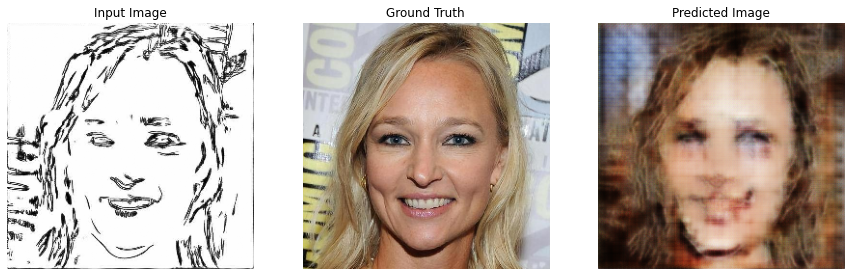

Step: 2k
Discriminator loss:  0.157708496
Generator GAN loss:  2.52908397
Generator L1 loss:  0.528571546
Generator total loss:  55.3862381
....................................................................................................
Time taken for 1000 steps: 1270.16 sec



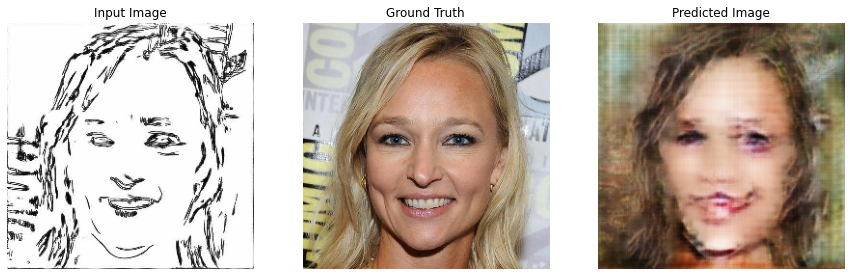

Step: 3k
Discriminator loss:  0.0322565883
Generator GAN loss:  3.84815311
Generator L1 loss:  0.575328529
Generator total loss:  61.3810043
....................................................................................................

In [38]:
fit(train_dataset, test_dataset, steps=4000)

In [39]:
log_dir

'./logs/'

In [41]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

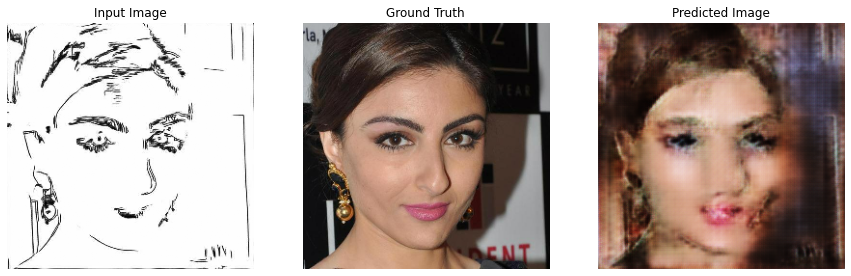

In [47]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(1):
  generate_images(generator, inp, tar)

In [48]:
import tensorflow as tf

# Define the paths to save weights
h5_save_path = './model_weights.h5'  # To save in HDF5 format
ckpt_save_path = './model_weights.ckpt'  # To save in TensorFlow checkpoint format

# Save the model in HDF5 format
generator.save_weights(h5_save_path)
print(f"Model weights saved in HDF5 format at: {h5_save_path}")

# Save the model in TensorFlow's native checkpoint format
generator.save_weights(ckpt_save_path)
print(f"Model weights saved in TensorFlow checkpoint format at: {ckpt_save_path}")


Model weights saved in HDF5 format at: ./model_weights.h5
Model weights saved in TensorFlow checkpoint format at: ./model_weights.ckpt
